# Baseline darts model

In [1]:
%reload_ext autoreload
%autoreload 2

# check if working in colab
try:
    # In colab
    from google.colab import drive
    drive.mount('/content/drive')

    %cd /content/drive/MyDrive/projects/paris-traffic-forecast
    %pip install -q darts

except:
    # In local
    # replace with your path
    %cd ..


/mnt/c/Users/Mustapha/Documents/competitions/BCG_Gamma/paris-traffic-forecast


In [2]:
from darts import TimeSeries

import matplotlib.pyplot as plt
from utils import load_data, plot_after
from darts.metrics import rmse
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_hist
from darts.datasets import AirPassengersDataset
import pandas as pd

plt.rcParams['figure.figsize'] = [20, 5]
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

## load data

In [4]:
# import data from csv
path_to_data='data/AV_Champs_Elysees.csv'
df = load_data(path_to_data)
df

,Identifiant arc,Libelle,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,Libelle noeud aval,Etat arc,Date debut dispo data,Date fin dispo data,geo_point_2d,geo_shape
Date et heure de comptage,,,,,,,,,,,,,,
2020-11-01 03:00:00,4264,AV_Champs_Elysees,34.0,0.40111,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.8715358799,2.30172279246","{""coordinates"": [[2.3009951475, 48.8717770435]..."
2020-11-01 04:00:00,4264,AV_Champs_Elysees,40.0,0.48389,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.8715358799,2.30172279246","{""coordinates"": [[2.3009951475, 48.8717770435]..."
2020-11-01 05:00:00,4264,AV_Champs_Elysees,66.0,0.75056,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.8715358799,2.30172279246","{""coordinates"": [[2.3009951475, 48.8717770435]..."
2020-11-01 06:00:00,4264,AV_Champs_Elysees,108.0,0.99611,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.8715358799,2.30172279246","{""coordinates"": [[2.3009951475, 48.8717770435]..."
2020-11-01 07:00:00,4264,AV_Champs_Elysees,126.0,1.09889,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.8715358799,2.30172279246","{""coordinates"": [[2.3009951475, 48.8717770435]..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-14 19:00:00,4264,AV_Champs_Elysees,1197.0,26.70056,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.8715358799,2.30172279246","{""coordinates"": [[2.3009951475, 48.8717770435]..."
2021-12-14 20:00:00,4264,AV_Champs_Elysees,1161.0,23.94667,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.8715358799,2.30172279246","{""coordinates"": [[2.3009951475, 48.8717770435]..."
2021-12-14 21:00:00,4264,AV_Champs_Elysees,974.0,19.09944,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.8715358799,2.30172279246","{""coordinates"": [[2.3009951475, 48.8717770435]..."


In [5]:
# transform data to TimeSeries
ts = TimeSeries.from_dataframe(df, 
                          value_cols=["Débit horaire", "Taux d'occupation"],
                          fill_missing_dates=True,
                          freq='H')
ts

<TimeSeries (DataArray) (Date et heure de comptage: 9813, component: 2, sample: 1)>
array([[[3.400000e+01],
        [4.011100e-01]],

       [[4.000000e+01],
        [4.838900e-01]],

       [[6.600000e+01],
        [7.505600e-01]],

       ...,

       [[9.740000e+02],
        [1.909944e+01]],

       [[9.300000e+02],
        [1.694222e+01]],

       [[8.910000e+02],
        [1.584945e+01]]])
Coordinates:
  * Date et heure de comptage  (Date et heure de comptage) datetime64[ns] 202...
  * component                  (component) object 'Débit horaire' "Taux d'occ...
Dimensions without coordinates: sample

9692 121
2020-11-01 03:00:00 2021-12-09 22:00:00
2021-12-09 23:00:00 2021-12-14 23:00:00


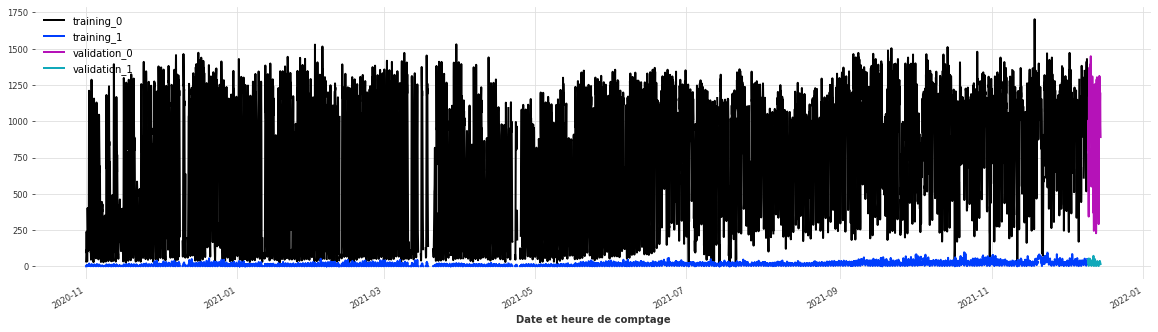

In [12]:
# train validation split
train, val = ts.split_before(ts.end_time().__sub__(pd.Timedelta(5, unit='D')))
print(len(train), len(val))
print(train.start_time(), train.end_time())
print(val.start_time(), val.end_time())
train.plot(label='training')
val.plot(label='validation')
plt.legend();

## Training model

RMSE: 271.9175194357024


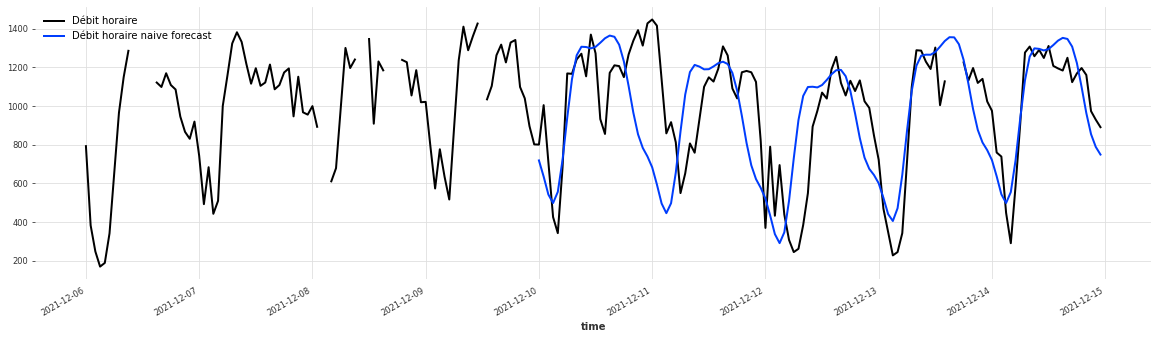

In [15]:
from darts.models import Prophet 
from darts.metrics import rmse

univariate_train = train.univariate_component(0)
univariate_val = val.univariate_component(0)
model = Prophet(country_holidays="FR")
model.fit(univariate_train)
naive_forecast = model.predict(len(univariate_val))

start_time = naive_forecast.start_time() - pd.Timedelta(4, unit='D')
plot_after(ts, 0, start_time)
plot_after(naive_forecast, 0, start_time, label='Débit horaire naive forecast')
plt.legend();
print("RMSE:", rmse(naive_forecast, univariate_val))
# univariate_val.plot()
# naive_forecast.plot()

RMSE: 190.84359704979192


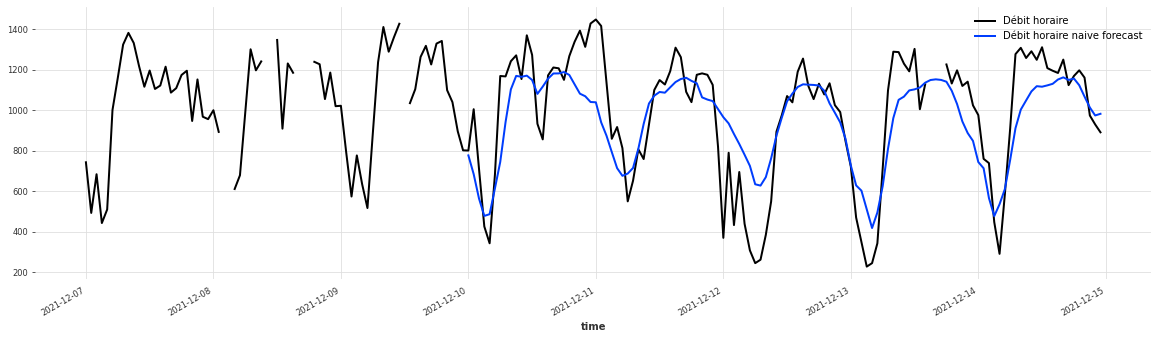

In [76]:
from darts.models import Prophet 
from darts.models import LightGBMModel
univariate_train = train.univariate_component(0)
univariate_train._xa.values = pd.DataFrame(univariate_train.values()).interpolate().to_numpy().reshape((-1, 1, 1))

univariate_val = val.univariate_component(0)
# model = Prophet(add_seasonalities={'name':"hourly seasonality", "seasonal_periods":24, "fourier_order":1} ,country_holidays="FR")
model = LightGBMModel(lags=300, max_depth = 5, num_leaves = 13, num_iterations = 50)
model.fit(univariate_train)
naive_forecast = model.predict(len(univariate_val))

start_time = naive_forecast.start_time() - pd.Timedelta(3, unit='D')
plot_after(ts, 0, start_time)
plot_after(naive_forecast, 0, start_time, label='Débit horaire naive forecast')
plt.legend();
print("RMSE:", rmse(naive_forecast, univariate_val))

In [77]:
model.backtest(univariate_train, forecast_horizon=len(univariate_val), start=0.8, stride=24, metric=rmse)


229.6923954240232

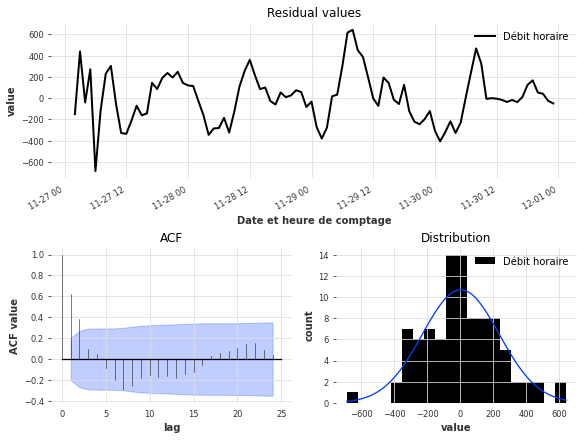

In [20]:
plot_residuals_analysis(model.residuals(univariate_val))